# Building our First Model

In [39]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import pandas as pd
import seaborn as sns
import time
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load in our train dataset's mean and standard deviation values we calculated previously.

In [3]:
mean = np.array([0.6760, 0.6308, 0.5746])
std = np.array([0.2055, 0.2108, 0.2250])

In [4]:
data_dir = 'garbage'
sets = ['train', 'test']

Define transformations. We may need to adjust the image size from Resize.

In [23]:
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

In [6]:
data_dir = 'garbage'
sets = ['train', 'test']

In [26]:
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
#                   for x in sets}

In [28]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, sets[0]), transform=data_transforms['train'])

Let's find out the distribution of our classes in the training dataset.

In [29]:
class_label_encoding_dict = train_dataset.class_to_idx
class_label_encoding_dict

{'PET': 0,
 'books_and_paper': 1,
 'burnable': 2,
 'cans': 3,
 'cardboard': 4,
 'clothes': 5,
 'danger': 6,
 'glass_bin': 7,
 'metal': 8,
 'nonburn': 9,
 'plastic': 10}

In [30]:
class_distribution = dict(collections.Counter(train_dataset.targets))
class_distribution

{0: 1450,
 1: 2843,
 2: 17197,
 3: 1722,
 4: 1944,
 5: 5346,
 6: 945,
 7: 2447,
 8: 1247,
 9: 3959,
 10: 1935}

In [31]:
for i, key in enumerate(class_label_encoding_dict.keys(), start=0):
    class_label_encoding_dict[key] = class_distribution[i]
class_label_encoding_dict

{'PET': 1450,
 'books_and_paper': 2843,
 'burnable': 17197,
 'cans': 1722,
 'cardboard': 1944,
 'clothes': 5346,
 'danger': 945,
 'glass_bin': 2447,
 'metal': 1247,
 'nonburn': 3959,
 'plastic': 1935}

Text(0.5, 1.0, 'Train Dataset Class Distribution')

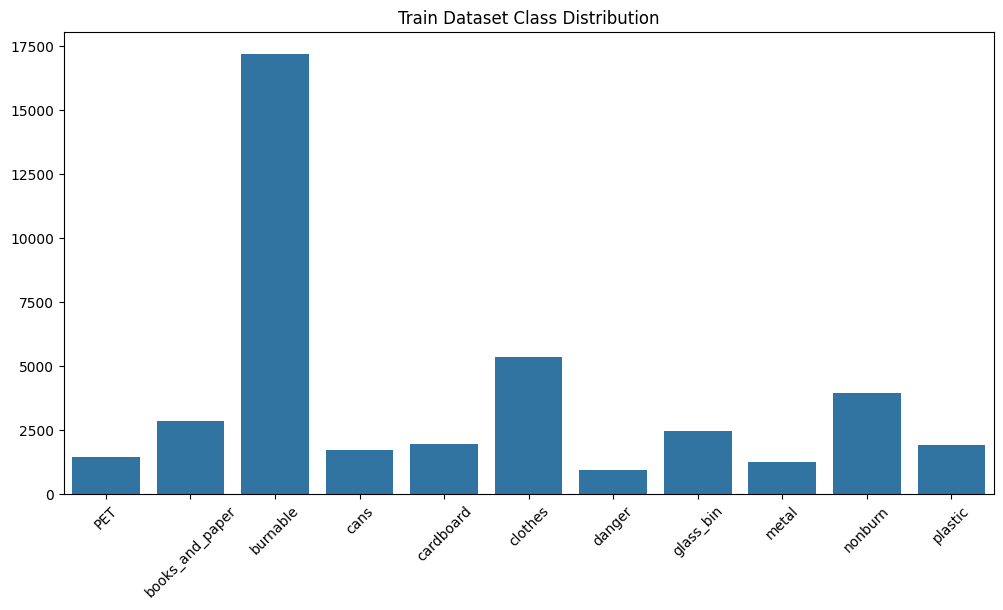

In [32]:
plt.figure(figsize=(12,6))
sns.barplot(class_label_encoding_dict)
plt.xticks(rotation=45)
plt.title('Train Dataset Class Distribution')

In [33]:
for key, value in class_label_encoding_dict.items():
    print(f'Dataset is {round(value/len(train_dataset)*100,2)}% {key}')

Dataset is 3.53% PET
Dataset is 6.93% books_and_paper
Dataset is 41.91% burnable
Dataset is 4.2% cans
Dataset is 4.74% cardboard
Dataset is 13.03% clothes
Dataset is 2.3% danger
Dataset is 5.96% glass_bin
Dataset is 3.04% metal
Dataset is 9.65% nonburn
Dataset is 4.72% plastic


In [35]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)

In [36]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 150, 300])
tensor([ 5,  2,  2, 10,  4,  2,  5,  0,  2,  9,  8,  2,  4,  5,  2,  2,  1,  2,
        10,  2,  2,  5,  2,  7,  3,  2,  2,  2,  2,  9,  5,  2])


Text(0.5, 1.0, 'Training Image Sample')

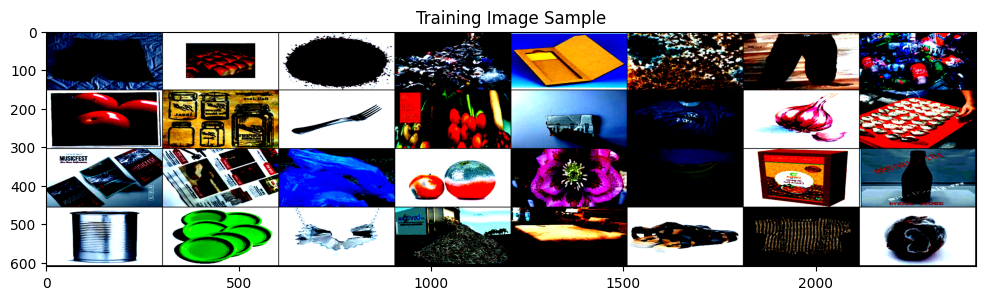

In [37]:
images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels)
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images))
plt.title('Training Image Sample')

In [40]:
dataset_size = len(train_dataset)

Define a training loop.

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('-'*10)

        # # each epoch has a training and validation phase
        # for phase in ['train', 'val']:
        #     if phase == 'train':
        #         model.train() # set model to training mode
        #     else:
        #         model.eval() # set model to validation mode

        running_loss = 0.0
        running_corrects = 0

            # Iterate over data
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

                #forward
                #track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model


Load in the pretrained VGG16 model with weights.

In [42]:
model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/ryantenbarge/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [Errno 60] Operation timed out>

Freeze model parameters.

In [ ]:
for param in model.parameters(): # freeze all the model parameters
    param.requires_grad = False

In [ ]:
# Check how many features are input to the final linear layer of the model
num_features = model.fc.in_features
num_features

In [ ]:
model.fc = torch.nn.Linear(in_features=num_features, out_features=11)
model.to(device)